<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

## Initial Checks 

In [ ]:
!conda list | grep "pytorch"

ffmpeg                    4.3                  hf484d3e_0    pytorch
libjpeg-turbo             2.0.0                h9bf148f_0    pytorch
pytorch                   2.0.1           py3.11_cuda11.8_cudnn8.7.0_0    pytorch
pytorch-cuda              11.8                 h7e8668a_5    pytorch
pytorch-ignite            0.4.12                   pypi_0    pypi
pytorch-lightning         2.0.7                    pypi_0    pypi
pytorch-mutex             1.0                        cuda    pytorch
torchaudio                2.0.2               py311_cu118    pytorch
torchtriton               2.0.0                     py311    pytorch
torchvision               0.15.2              py311_cu118    pytorch


In [ ]:
!nvcc --version

/bin/bash: line 1: nvcc: command not found


In [ ]:
!pip list | grep "fastai" 
!pip list | grep "fastbook"
!pip list | grep "ipywidgets"

fastai                        2.7.12
fastbook                      0.0.28
ipywidgets                    8.0.4


In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

## Gather Data

In [ ]:
from fastbook import search_images_ddg
from fastdownload import download_url
from fastai.vision.all import *
from nbdevAuto.functions import *
import os

In [ ]:
?download_pic

Signature:
download_pic(
    image: str,
    n_images: int = 1,
    name: str = '',
    folder: str = '',
    show_progress: bool = False,
    recreate: bool = False,
)
Docstring: Downloads the image into the folder provided and displays it
File:      ~/mambaforge/envs/cfast/lib/python3.11/site-packages/nbdevAuto/functions.py
Type:      function

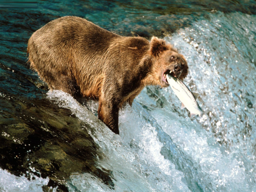

In [ ]:
dest = 'grizzly'
download_pic(dest, folder = './Data')

In [ ]:
#|code-fold: true
searches = ('grizzly bears','black bears','teddy bears')
path = Path('Data/bears')

create_data_folder(path, searches)

created grizzly bears folder
created black bears folder
created teddy bears folder
downloading 200 images for:grizzly bears
downloading 200 images for:black bears
downloading 200 images for:teddy bears
Number of images failed: 31
resizing images for: grizzly bears
resizing images for: black bears
resizing images for: teddy bears


## Data Augmentation and Designing model

In [ ]:
?DataBlock

Init signature:
DataBlock(
    blocks: 'list' = None,
    dl_type: 'TfmdDL' = None,
    getters: 'list' = None,
    n_inp: 'int' = None,
    item_tfms: 'list' = None,
    batch_tfms: 'list' = None,
    *,
    get_items=None,
    splitter=None,
    get_y=None,
    get_x=None,
)
Docstring:      Generic container to quickly build `Datasets` and `DataLoaders`.
File:           ~/mambaforge/envs/cfast/lib/python3.11/site-packages/fastai/data/block.py
Type:           type
Subclasses:     

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = bears.dataloaders(path)

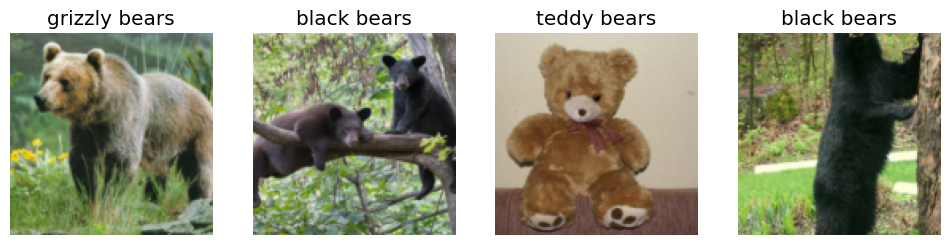

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

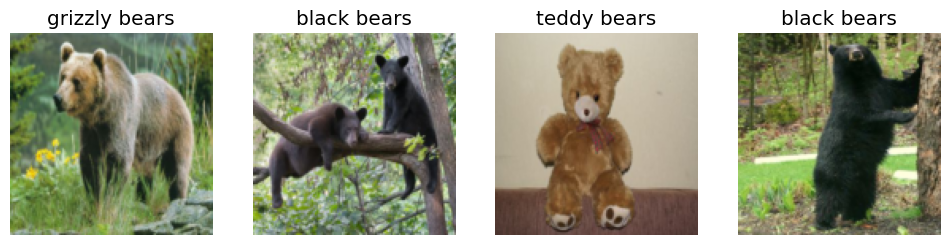

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

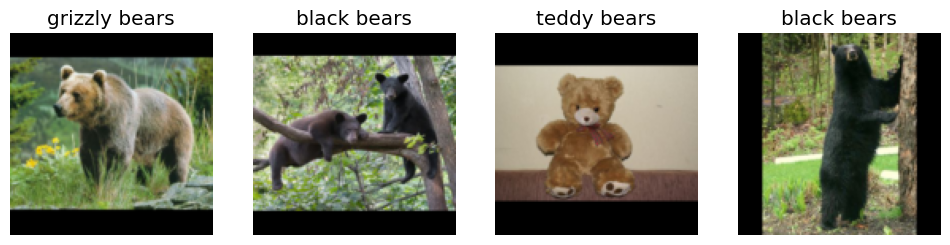

In [ ]:
bears = bears.new(
    item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

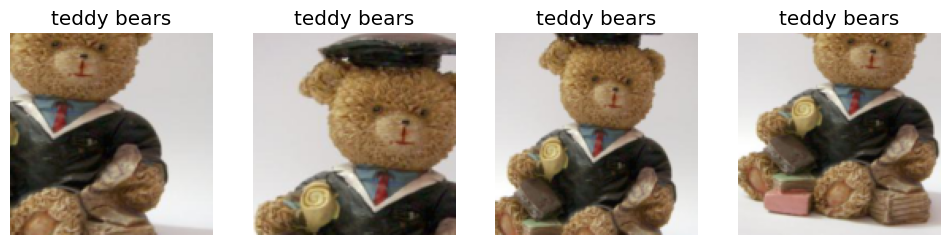

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Training Your Model, and Using It to Clean Your Data

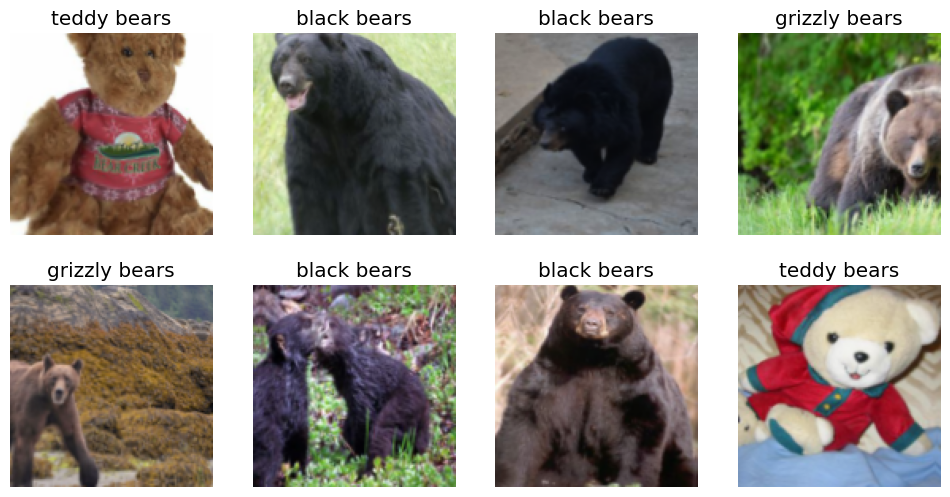

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(128, min_scale=0.5),
    batch_tfms=aug_transforms(mult=1))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=False)

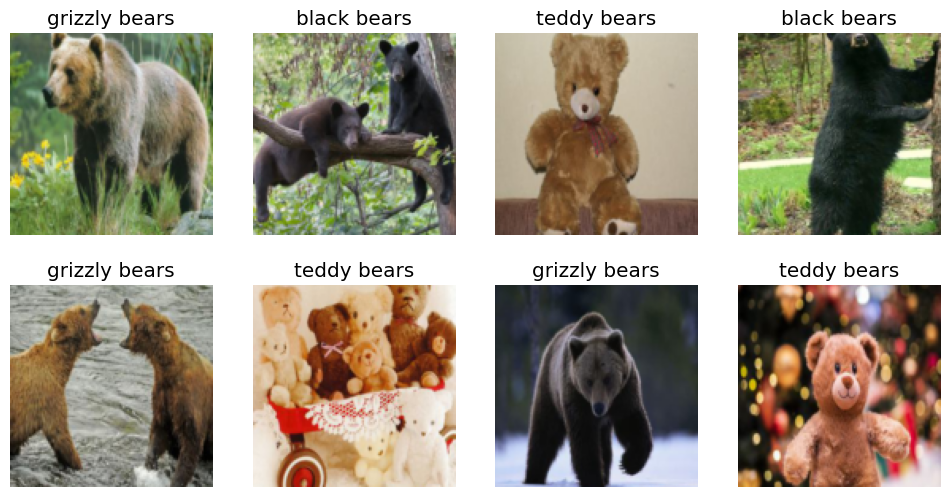

In [ ]:
dls.valid.show_batch(max_n=8, nrows=2, unique=False)

## Training Your Model

In [ ]:
import timm

In [ ]:
timm.list_models('resnet1*')[0:5]

['resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet101']

In [ ]:
learn = vision_learner(dls,  'resnet18', metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.391607,0.352104,0.127273,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.575542,0.227657,0.081818,00:03
1,0.482945,0.238172,0.063636,00:02
2,0.428172,0.271056,0.090909,00:02
3,0.371018,0.263265,0.063636,00:02
4,0.326668,0.267179,0.063636,00:02


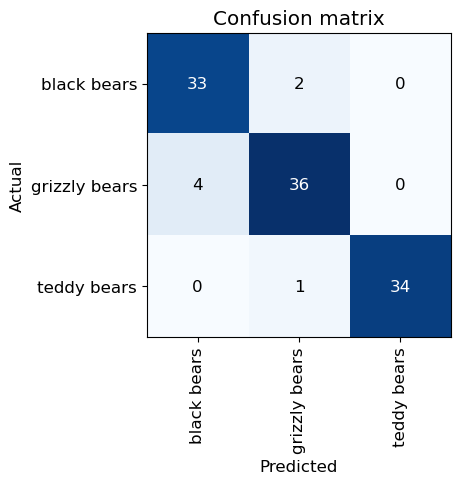

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

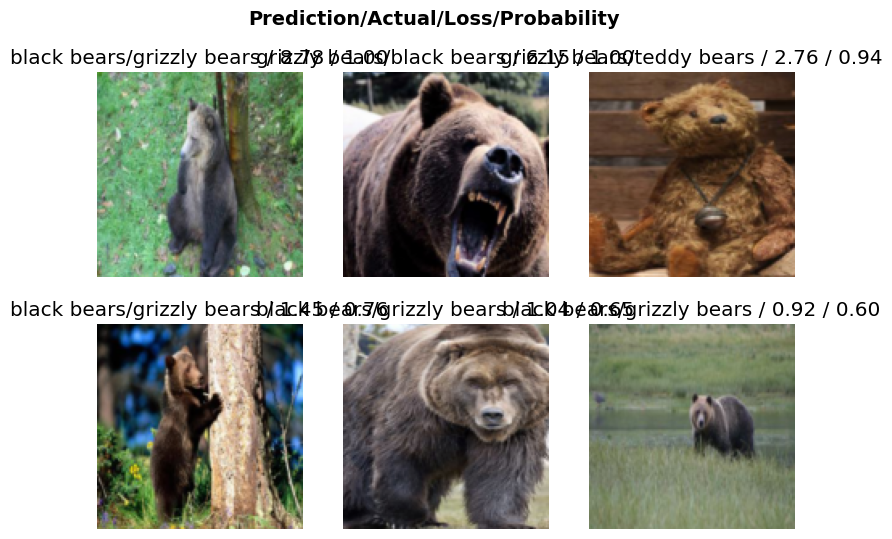

In [ ]:
interp.plot_top_losses(6, nrows=2)

In [ ]:
from fastai.vision.widgets import ImageClassifierCleaner

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Testing

Probability of grizzly bears is :0.00892.
Probability of black bears is :0.99068.
Probability of teddy bears is :0.00040.
This is a: black bears with probability: 0.99068.


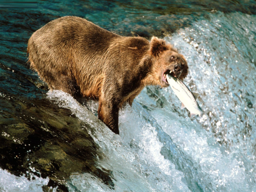

In [ ]:
searches = ('grizzly bears','black bears','teddy bears')
image= 'Data/grizzly0.jpg'


is_real,_,probs = learn.predict(PILImage.create(image))

for index, value in enumerate(searches):
    np.set_printoptions(suppress=True, precision=4)
    print(f"Probability of {value} is :{probs[index]:.5f}.")
    
max_value, max_index = torch.max(probs, dim=0)
print(f"This is a: {searches[max_index]} with probability: {max_value:.5f}.")


Image.open(image).to_thumb(256,256)

## Turning Your Model into an Online Application

In [ ]:
if os.path.exists('Data/model.pkl'):
    print("model already exists")
else:
    learn.export('Data/model.pkl')
    print("model created")

model created


In [ ]:
path = Path('Data')
filename = path.ls(file_exts='.pkl')
filename[0].name

'model.pkl'

In [ ]:
learn_inf = load_learner(path/filename[0].name)

CPU times: user 440 ms, sys: 14.4 ms, total: 455 ms
Wall time: 123 ms


('grizzly bears', tensor(1), tensor([8.9228e-03, 9.9068e-01, 3.9536e-04]))

In [ ]:
learn_inf.dls.vocab

['black bears', 'grizzly bears', 'teddy bears']

## Making a widget application

In [ ]:
!pip list | grep 'ipywidgets'
!pip list | grep 'ipywidgets'

ipywidgets                    8.0.4
ipywidgets                    8.0.4


In [ ]:
import ipywidgets as widgets

In [ ]:
btn_upload = widgets.FileUpload(
    button_style='success',
    description='Upload',
    accept='',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)
display(btn_upload)

FileUpload(value=(), button_style='success', description='Upload')

In [ ]:
if btn_upload.value:
    uploaded_image = Image.open(io.BytesIO(btn_upload.value[-1].content)).to_thumb(256,256)
    display(uploaded_image)

In [ ]:
out_pl = widgets.Output()
display(out_pl)

Output()

In [ ]:
if btn_upload.value:
    out_pl = widgets.Output()
    out_pl.clear_output()
    with out_pl: display(uploaded_image)
    out_pl

In [ ]:
if btn_upload.value:
    uploaded_image = Image.open(io.BytesIO(btn_upload.value[-1].content)).to_thumb(256,256)
    pred,pred_idx,probs = learn_inf.predict(uploaded_image)

In [ ]:
#hide_output
if btn_upload.value:
    lbl_pred = widgets.Label()
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    display(lbl_pred)

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    if btn_upload.value:
        img = Image.open(io.BytesIO(btn_upload.value[-1].content)).to_thumb(256,256)
        out_pl.clear_output()
        with out_pl: display(img)
        pred,pred_idx,probs = learn_inf.predict(img)
        lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    else:
        lbl_pred.value = f'Select image'

btn_run.on_click(on_click_classify)

In [ ]:
if btn_upload.value:
    lbl_pred

In [ ]:
screen = widgets.VBox([widgets.Label('Select your bear!'), 
              btn_upload,
              btn_run,
              out_pl, 
              lbl_pred:= widgets.Label()]
            )
display(screen)